# Classifying Patient Abilify Ratings from WebMD

## Setup

In [1]:
# imports

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import tensorflow as tf
import gensim

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# set random seeds
np.random.seed(0)
tf.random.set_seed(0)

In [3]:
# download WordNet model for lemmatization

nltk.download('wordnet')
!unzip /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/

[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
Archive:  /usr/share/nltk_data/corpora/wordnet.zip
   creating: /usr/share/nltk_data/corpora/wordnet/
  inflating: /usr/share/nltk_data/corpora/wordnet/lexnames  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adv  
  inflating: /usr/share/nltk_data/corpora/wordnet/adv.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/cntlist.rev  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/LICENSE  
  inflating: /usr/share/nltk_data/corpora/wordnet/citation.bib  
  inflating: /usr/share/nltk_data/corpora/wordnet/noun.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/verb.exc  
  inflating: /usr/share/nltk_data/co

In [4]:
# load dataset
# https://www.kaggle.com/datasets/joyshil0599/abilify-oral-reviews-dataset

corpus = pd.read_csv('/kaggle/input/abilify-oral-reviews-dataset/abilify_ora_effected_peple_reviewl.csv',
                     encoding_errors='replace') # use replacement character for characters not in UTF-8
corpus = corpus[['overall-rating', 'description-text']]

print(f'Before dropping NAs: {len(corpus)}')
corpus = corpus.dropna(axis=0)
corpus = corpus.reset_index(drop=True)
print(f'After dropping NAs: {len(corpus)}')

corpus.head(5)

Before dropping NAs: 1835
After dropping NAs: 1540


,overall-rating,description-text
0,5.0,I've taken Abilify to augment bupropion for Bi...
1,2.0,Worked for 3 months. Waste of time. You think ...
2,2.3,Worked really well for like 2 months then I go...
3,1.0,This is the worst drug on the market. It cause...
4,2.0,I was prescribed as a child at 15 years old. I...


## Exploratory Data Analysis

/opt/conda/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


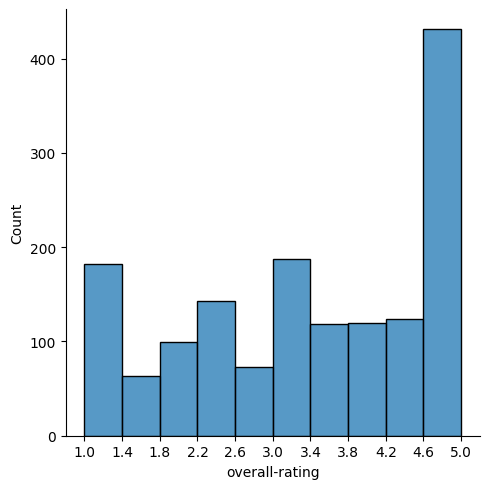

In [5]:
# view distribution of ratings

bins = 10
bin_width = (5-1)/bins
ax = sns.displot(corpus, x='overall-rating', bins=bins)
plt.xticks(np.arange(1, 5+bin_width, bin_width))

plt.show()

<Axes: xlabel='rating_rounded', ylabel='count'>

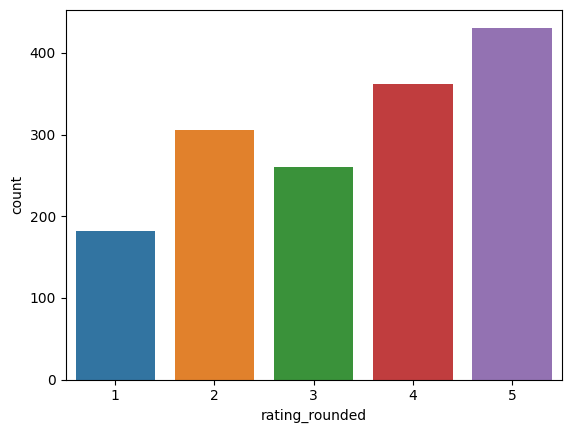

In [6]:
# round ratings and view distribution

corpus['rating_rounded'] = corpus['overall-rating'].round().astype(int)
sns.countplot(corpus, x='rating_rounded')

In [45]:
# TODO: add word cloud
# https://www.datacamp.com/tutorial/wordcloud-python

## Text Preprocessing
https://geeksforgeeks.org/python-word-embedding-using-word2vec/ \
https://spotintelligence.com/2022/12/21/nltk-preprocessing-pipeline/

In [7]:
# !pip install pyspellchecker

In [8]:
# # correct spellings

# from spellchecker import SpellChecker
# from tqdm import tqdm

# corpus['spellchecked-text'] = corpus['description-text'].copy()

# speller = SpellChecker()
# speller.distance = 2
# speller.word_frequency.load_words(['Abilify', 'Lexapro', 'SSRI', 'Lamictal', 'Klonopin', 'Latuda', 'escitalopram', 'aripiprazole', 'risperdal'])

# for i, sentence in enumerate(tqdm(corpus['description-text'])):
#     words = sentence.split(' ')
#     corpus.loc[i, 'spellchecked-text'] = ' '.join([speller.correction(word) if speller.correction(word) is not None else word for word in words])

# # print the words unrecognized by the spellchecker

# from itertools import chain
# words = np.unique(list(chain(*[sentence.split(' ') for sentence in corpus['spellchecked-text']])))
# speller.unknown(words)

# # save and inspect result of spell checking

# corpus.to_csv('abilify-reviews-spellchecked.csv')
# corpus.head(10)

In [9]:
# load already spellchecked corpus
corpus = pd.read_csv('/kaggle/input/abilify-reviews-spellchecked/abilify-reviews-spellchecked.csv')

In [10]:
# apply preprocessing steps - tokenization, lowercase, remove punctuation, lemmatization

from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import string

stopwords = nltk.corpus.stopwords.words('english')
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    tokens = word_tokenize(text)
    tokens_lower = [token.lower() for token in tokens]
    tokens_no_punct = [token for token in tokens_lower if token not in string.punctuation]
    # tokens_no_stopwords = [token for token in tokens_no_punct if token not in stopwords]
    tokens_lemmatized = [lemmatizer.lemmatize(token) for token in tokens_no_punct]
    sentence = ' '.join(tokens_lemmatized)
    return sentence

In [11]:
corpus['text_preprocessed'] = corpus['spellchecked-text'].apply(preprocess_text)
corpus['text_preprocessed'].head(5)

0    i 've taken abilify to augment bupropion for b...
1    worked for 3 month waste of time you think you...
2    worked really well for like 2 month then i got...
3    this is the worst drug on the market it caused...
4    i wa prescribed a a child at 15 year old it ca...
Name: text_preprocessed, dtype: object

In [12]:
# generate sequences (encode tokens using numeric values) that are padded to the same length
# make equal length sequences in order to use as neural network input

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

VOCAB_SIZE = 3000
MAX_SEQUENCE_LENGTH = 150

tokenizer = Tokenizer(oov_token='<OOV>', num_words=VOCAB_SIZE)

sentences = corpus['text_preprocessed']

# generate word indexes
tokenizer.fit_on_texts(sentences)

# generate sequences and apply padding
sequences = tokenizer.texts_to_sequences(sentences)
sequences_padded = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH, padding='post')

In [13]:
words_sentences = [x.split() for x in sentences]

## Set Up Evaluation Metrics

In [14]:
# compute accuracy and plot confusion matrix

from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay, confusion_matrix

def evaluation(y_test, y_pred):
    print(f'accuracy: {accuracy_score(y_test, y_pred):.4f}')

    fig, ax = plt.subplots(1, 1, figsize=(6, 6))
    cm = confusion_matrix(y_test, y_pred)
    classes = np.unique(y_test) + 1  # sorted in ascending order
    cm_plot = ConfusionMatrixDisplay(cm, display_labels=classes)
    cm_plot.plot(cmap='Blues', ax=ax)
    im = cm_plot.im_
    im.colorbar.remove()
    plt.colorbar(im, orientation='horizontal', pad=0.2, label='Number of samples')

    plt.title('');

## Bag of Words and Naive Bayes
Adapted from Natural Language Processing in Action book[](http://)

In [15]:
# produce BOW

from collections import Counter                                    

bags_of_words = [Counter(sentence) for sentence in words_sentences]
df_bows = pd.DataFrame.from_records(bags_of_words)                  
df_bows = df_bows.fillna(0).astype(int)
df_bows.head(5)

,i,'ve,taken,abilify,to,augment,bupropion,for,bipolar,disorder,...,welt,true,unhappy,environment,behind,wheel,full-blown,interferes,weekend,alleviating
0,4,2,1,1,1,1,1,2,1,1,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,4,1,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,0,0,0,3,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [16]:
# train-test split

from sklearn.model_selection import train_test_split

y = corpus['rating_rounded'] - 1  # get labels 0-4 instead of 1-5

test_fraction = 0.2
X_train, X_test, y_train, y_test = train_test_split(df_bows,
                                                    y,
                                                    test_size=test_fraction,
                                                    shuffle=True,
                                                    random_state=0
                                                    )

# subset of 1 and 5 star ratings
keep_train = (y_train == 0) | (y_train == 4)
keep_test = (y_test == 0) | (y_test == 4)

X_train_subset = X_train[keep_train]
y_train_subset = y_train[keep_train]
y_train_subset = np.array([y if y==0 else 1 for y in y_train_subset])

X_test_subset = X_test[keep_test]
y_test_subset = y_test[keep_test]
y_test_subset = np.array([y if y==0 else 1 for y in y_test_subset])

accuracy: 0.7710


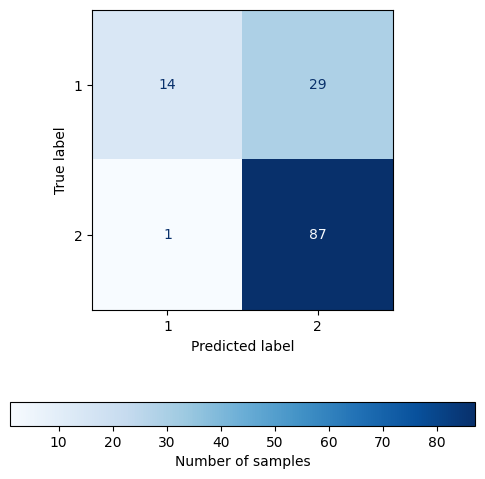

In [17]:
# fit naive Bayes, predict, and evaluate performance

from sklearn.naive_bayes import MultinomialNB

model = MultinomialNB()
model.fit(X_train_subset, y_train_subset)

y_pred = model.predict(X_test_subset)

evaluation(y_test_subset, y_pred)

In [18]:
# inspect some misclassified samples

one_star_misclassified = X_test_subset[(y_test_subset == 0) & (y_pred == 1)]
for row in one_star_misclassified.iterrows():
    print(one_star_misclassified.columns[row[1] != 0])

Index(['i', 'abilify', 'now', 'it', ''s', 'effect', 'of', '2', 'wa', 'just',
       'is', 'than', 'before', 'long', 'eating', 'an', 'about', 'ago', 'how',
       'feel', 'am', 'le', 'health', 'began', '...', 'concerned', 'sleeping',
       'nausea', 'horrible..trouble', 'therapeutic', 'rn..and', 'risks/side',
       'desired', 'helpfullness'],
      dtype='object')
Index(['i', 'to', 'and', 'it', 'the', 'from', 'all', 'my', 'wa', 'with',
       'having', 'on', 'over', 'or', 'out', 'very', 'up', 'rash', 'body',
       'felt', 'when', 'sent', 'energy', 'right', 'came', 'room', 'emergency',
       'ended', 'emotion', 'switched', 'geodon', 'numb', 'inside', 'welt',
       'true', 'unhappy'],
      dtype='object')
Index(['i', 'to', 'for', 'and', 'depression', 'year', 'it', 'the', 'a', 'of',
       'month', 'better', 'really', 'my', 'with', 'this', 'is', 'on', 'me',
       'company', 'in', 'an', 'insurance', 'added', 'issue', 'feeling',
       'helped', 'am', 'until', 'when', 'first', 'finall

## TF-IDF and Latent Semantic Analysis (LSA)
Adapted from Natural Language Processing in Action book[](http://)

In [19]:
# produce TF-IDF matrix

from sklearn.feature_extraction.text import TfidfVectorizer

extreme_bool = (y == 0) | (y == 4)

tfidf_model = TfidfVectorizer()
tfidf_matrix = tfidf_model.fit_transform(sentences[extreme_bool]).toarray()
tfidf_matrix = tfidf_matrix - tfidf_matrix.mean(axis=0) # center data
tfidf_matrix = (tfidf_matrix.T / np.linalg.norm(tfidf_matrix, axis=1)).T  # normalize with L2 norm (vector length)
tfidf_matrix[:5]

array([[-0.00107589, -0.00032787, -0.001213  , ..., -0.00161705,
        -0.00036611, -0.0025838 ],
       [-0.00108791, -0.00033153, -0.00122656, ..., -0.00163512,
        -0.0003702 , -0.00261267],
       [-0.00108742, -0.00033139, -0.00122601, ..., -0.00163438,
        -0.00037004, -0.00261149],
       [-0.00111056, -0.00033844, -0.00125209, ..., -0.00166916,
        -0.00037791, -0.00266706],
       [-0.00110401, -0.00033644, -0.00124471, ..., -0.00165932,
        -0.00037568, -0.00265134]])

In [20]:
# perform truncated SVD

from sklearn.decomposition import TruncatedSVD
 
svd = TruncatedSVD(n_components=16, n_iter=100)
svd_topic_vectors = svd.fit_transform(tfidf_matrix)

<Axes: >

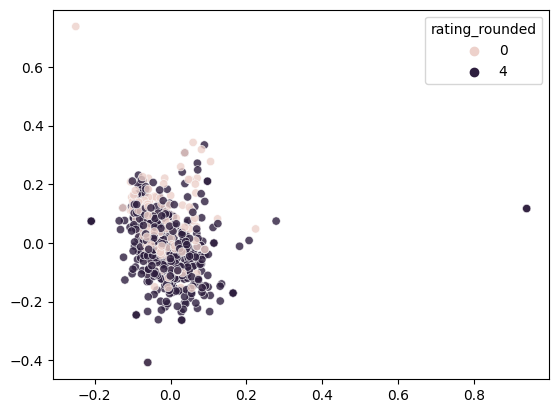

In [21]:
# plot first 2 PCs and color by 1 vs 5 star reviews

x_coord = np.array([doc[0] for doc in svd_topic_vectors])
y_coord = np.array([doc[1] for doc in svd_topic_vectors])

sns.scatterplot(x=x_coord, y=y_coord, hue=y[extreme_bool], alpha=0.8)

accuracy: 0.7398


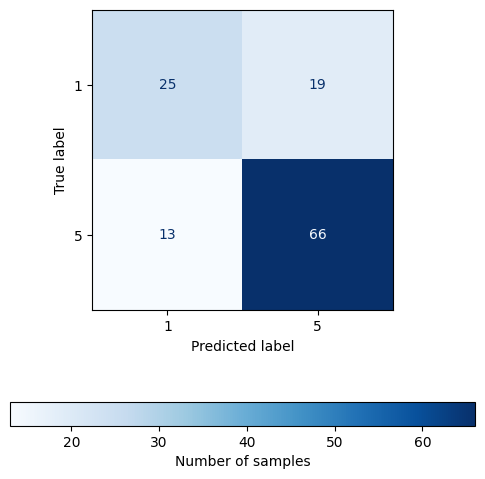

In [22]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

X_train, X_test, y_train, y_test = train_test_split(svd_topic_vectors, y[extreme_bool], test_size=0.2, random_state=0)
model = LinearDiscriminantAnalysis(n_components=1)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

evaluation(y_test, y_pred)

## Word2Vec and Convolutional Neural Network (CNN)
Adapted from Natural Language Processing in Action book[](http://)

In [23]:
EMBEDDING_DIM = 300

w2v_file = '/kaggle/input/googlenewsvectorsnegative300/GoogleNews-vectors-negative300.bin'
w2v_model = gensim.models.KeyedVectors.load_word2vec_format(w2v_file, binary=True)

In [24]:
# https://blog.keras.io/using-pre-trained-word-embeddings-in-a-keras-model.html

word_index = tokenizer.word_index
word_list = sorted(word_index.items(), key=lambda x:x[1])
word_list = [x[0] for x in word_list]

embedding_values = [w2v_model[word] if word in w2v_model else np.zeros(EMBEDDING_DIM) for word in word_list]
embedding_matrix = np.vstack([np.zeros([1, EMBEDDING_DIM]),
                             np.array(embedding_values)])

In [25]:
np.array(word_list)[np.sum(embedding_matrix[1:], axis=1)==0]

array(['<OOV>', 'and', 'to', 'a', 'of', 'abilify', "'s", '10', '15', '30',
       '10mg', '50', '20', '15mg', '40', '60lbs', '20mg', 'ocd', '300mg',
       '100', '14', '60', 'trazadone', '700', '18', '25', '300', "''",
       '30mg', '00', '12', '45', '1wk', '60mg', '24', 'geodon', 'ptsd',
       '80', '16', 'lightheadness', 'risperdal', '150mg', '100mg', '500',
       '38', '99', '70lbs', '250mg', '200', '35', '17', '90', '200mg',
       '19', 'ablify', '150', '25mg', '225mg', 'remeron', '125', '2009',
       'lbo', '11', '09', 'clonic', 'benztropine', 'akathesia', '13',
       '50mg', 'grey', '117', '600mg', '450', '40mg', 'viibryd', '225',
       'aniouty', '900', '40lbs', 'pristiq', '2011', '2012', 'welbutrin',
       '400', 'diskenesia', 'ssri', 'andlor', '600', '56', 'timei', '37',
       '54', 'diabetis', '100lbs', '2004', '2006', 'risparadal', '158',
       'wellbutrinxl', '20lbs', '768', '2019', '234', 'szichsophrenia',
       '730', "it'ii", 'didn�', 'latuda', '000', 'dissfo

In [26]:
from tensorflow.keras.layers import Embedding

embedding_layer = Embedding(len(word_index)+1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)

In [27]:
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Flatten, Dense, Dropout, GlobalMaxPooling1D
from tensorflow.keras import Model

# 1 and 5 star ratings only
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)
x = Conv1D(128, 3, activation='relu')(embedded_sequences)
x = MaxPooling1D(3)(x)
x = Dropout(0.2)(x)
x = Conv1D(128, 3, activation='relu')(x)
x = MaxPooling1D(3)(x)
x = Dropout(0.2)(x)
x = Conv1D(64, 3, activation='relu')(x)
x = MaxPooling1D(3)(x)
x = Dropout(0.2)(x)
x = GlobalMaxPooling1D()(x)
x = Dropout(0.1)(x)
x = Flatten()(x)
x = Dense(32, activation='relu')(x)
preds = Dense(2, activation='softmax')(x)

model = Model(sequence_input, preds)
opt = tf.keras.optimizers.Adam(learning_rate=1e-3)
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

In [28]:
test_fraction = 0.2
X_train, X_test, y_train, y_test = train_test_split(sequences_padded,
                                                    y,
                                                    test_size=test_fraction,
                                                    shuffle=True,
                                                    random_state=0
                                                    )

# subset of 1 and 5 star ratings
keep_train = (y_train == 0) | (y_train == 4)
keep_test = (y_test == 0) | (y_test == 4)

X_train_subset = X_train[keep_train]
y_train_subset = y_train[keep_train]
y_train_subset = np.array([y if y==0 else 1 for y in y_train_subset])

X_test_subset = X_test[keep_test]
y_test_subset = y_test[keep_test]
y_test_subset = np.array([y if y==0 else 1 for y in y_test_subset])

In [29]:
from sklearn.utils import class_weight

classes = [0, 1]
class_weights = class_weight.compute_class_weight('balanced', classes=classes, y=y_train_subset)
class_weights = dict(enumerate(class_weights))

In [30]:
model.fit(X_train_subset,
          y_train_subset,
          epochs=50,
          batch_size=64,
          validation_split=0.1,
          class_weight=class_weights)

y_pred = model.predict(X_test_subset)
y_pred_label = [np.argmax(y) for y in y_pred]

Epoch 1/50
7/7 [==============================] - 12s 85ms/step - loss: 0.7027 - accuracy: 0.6074 - val_loss: 0.6884 - val_accuracy: 0.5102
Epoch 2/50
7/7 [==============================] - 0s 11ms/step - loss: 0.6811 - accuracy: 0.5035 - val_loss: 0.6873 - val_accuracy: 0.5510
Epoch 3/50
7/7 [==============================] - 0s 10ms/step - loss: 0.6872 - accuracy: 0.6443 - val_loss: 0.6730 - val_accuracy: 0.6122
Epoch 4/50
7/7 [==============================] - 0s 10ms/step - loss: 0.6602 - accuracy: 0.5658 - val_loss: 0.7066 - val_accuracy: 0.3878
Epoch 5/50
7/7 [==============================] - 0s 11ms/step - loss: 0.6445 - accuracy: 0.6490 - val_loss: 0.6642 - val_accuracy: 0.6735
Epoch 6/50
7/7 [==============================] - 0s 10ms/step - loss: 0.5918 - accuracy: 0.7298 - val_loss: 0.6389 - val_accuracy: 0.6939
Epoch 7/50
7/7 [==============================] - 0s 11ms/step - loss: 0.5116 - accuracy: 0.7852 - val_loss: 0.6390 - val_accuracy: 0.5714
Epoch 8/50
7/7 [==========

accuracy: 0.8168


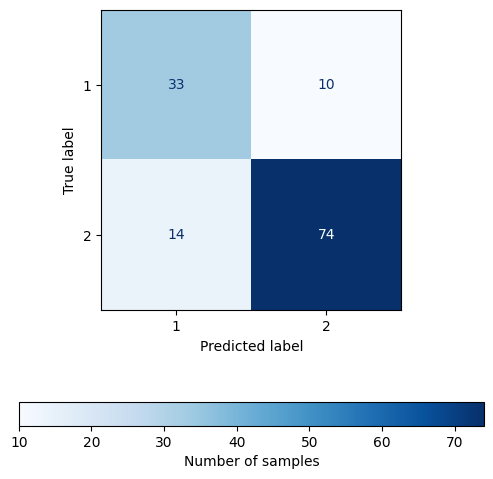

In [31]:
evaluation(y_test_subset, y_pred_label)

## GloVe and CNN

In [32]:
# from gensim.scripts.glove2word2vec import glove2word2vec

glove_file = '/kaggle/input/glove6b/glove.6B.300d.txt'
# w2v_output_file = glove_file + '.word2vec'
# glove2word2vec(glove_file, w2v_output_file)

glove_model = gensim.models.KeyedVectors.load_word2vec_format(
                glove_file,
                binary=False,
                no_header=True)

In [33]:
embedding_values = [glove_model[word] if word in glove_model else np.zeros(EMBEDDING_DIM) for word in word_list]
embedding_matrix = np.vstack([np.zeros([1, EMBEDDING_DIM]),
                             np.array(embedding_values)])
                             
embedding_layer = Embedding(len(word_index)+1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)

In [34]:
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Flatten, Dense, Dropout, GlobalMaxPooling1D
from tensorflow.keras import Model

# 1 and 5 star ratings only
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)
x = Conv1D(128, 3, activation='relu')(embedded_sequences)
x = MaxPooling1D(3)(x)
x = Dropout(0.2)(x)
x = Conv1D(64, 3, activation='relu')(x)
x = MaxPooling1D(3)(x)
x = Dropout(0.2)(x)
x = GlobalMaxPooling1D()(x)
x = Dropout(0.1)(x)
x = Flatten()(x)
x = Dense(32, activation='relu')(x)
preds = Dense(2, activation='softmax')(x)

model = Model(sequence_input, preds)
opt = tf.keras.optimizers.Adam(learning_rate=1e-3)
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

In [35]:
model.fit(X_train_subset,
          y_train_subset,
          epochs=50,
          batch_size=64,
          validation_split=0.1,
          class_weight=class_weights)

y_pred = model.predict(X_test_subset)
y_pred_label = [np.argmax(y) for y in y_pred]

Epoch 1/50
7/7 [==============================] - 2s 58ms/step - loss: 0.7369 - accuracy: 0.5543 - val_loss: 0.7300 - val_accuracy: 0.3878
Epoch 2/50
7/7 [==============================] - 0s 10ms/step - loss: 0.6833 - accuracy: 0.6536 - val_loss: 0.6442 - val_accuracy: 0.6735
Epoch 3/50
7/7 [==============================] - 0s 10ms/step - loss: 0.6090 - accuracy: 0.6905 - val_loss: 0.6411 - val_accuracy: 0.6939
Epoch 4/50
7/7 [==============================] - 0s 10ms/step - loss: 0.5720 - accuracy: 0.7113 - val_loss: 0.5836 - val_accuracy: 0.6735
Epoch 5/50
7/7 [==============================] - 0s 10ms/step - loss: 0.4893 - accuracy: 0.8199 - val_loss: 0.5629 - val_accuracy: 0.7143
Epoch 6/50
7/7 [==============================] - 0s 10ms/step - loss: 0.4229 - accuracy: 0.8591 - val_loss: 0.5816 - val_accuracy: 0.6939
Epoch 7/50
7/7 [==============================] - 0s 10ms/step - loss: 0.3901 - accuracy: 0.8383 - val_loss: 0.5124 - val_accuracy: 0.7551
Epoch 8/50
7/7 [===========

accuracy: 0.7786


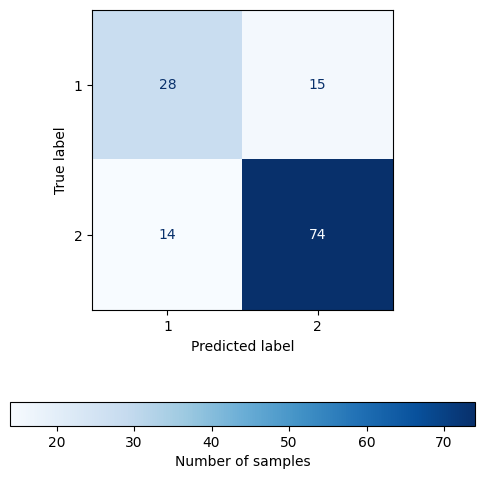

In [36]:
evaluation(y_test_subset, y_pred_label)

## Bidirectional Recurrent Neural Network (RNN)
Adapted from Natural Language Processing in Action book

In [37]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import SimpleRNN
from tensorflow.keras.layers import Bidirectional

model = Sequential()
model.add(Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32'))
model.add(embedding_layer)
model.add(Bidirectional(SimpleRNN(
            128,
            return_sequences=False,
            input_shape=(MAX_SEQUENCE_LENGTH, EMBEDDING_DIM))))
model.add(Dropout(0.4))
model.add(Flatten())
model.add(Dense(2, activation='softmax'))

model.compile('rmsprop', 'sparse_categorical_crossentropy',  metrics=['accuracy'])

with tf.device('/gpu:0'):
    model.fit(X_train_subset,
              y_train_subset,
              epochs=20,
              batch_size=32,
              validation_split=0.1,
              class_weight=class_weights)

Epoch 1/20
14/14 [==============================] - 6s 219ms/step - loss: 0.8661 - accuracy: 0.4850 - val_loss: 0.7801 - val_accuracy: 0.5306
Epoch 2/20
14/14 [==============================] - 3s 195ms/step - loss: 0.5726 - accuracy: 0.6998 - val_loss: 0.6923 - val_accuracy: 0.6531
Epoch 3/20
14/14 [==============================] - 3s 197ms/step - loss: 0.5277 - accuracy: 0.7621 - val_loss: 0.7133 - val_accuracy: 0.5918
Epoch 4/20
14/14 [==============================] - 3s 192ms/step - loss: 0.4038 - accuracy: 0.8060 - val_loss: 0.7256 - val_accuracy: 0.6735
Epoch 5/20
14/14 [==============================] - 3s 195ms/step - loss: 0.3257 - accuracy: 0.8776 - val_loss: 0.8571 - val_accuracy: 0.5510
Epoch 6/20
14/14 [==============================] - 3s 197ms/step - loss: 0.2780 - accuracy: 0.8845 - val_loss: 0.8695 - val_accuracy: 0.5102
Epoch 7/20
14/14 [==============================] - 3s 195ms/step - loss: 0.2248 - accuracy: 0.8915 - val_loss: 0.8824 - val_accuracy: 0.5510
Epoch 

5/5 [==============================] - 0s 24ms/step
accuracy: 0.6565


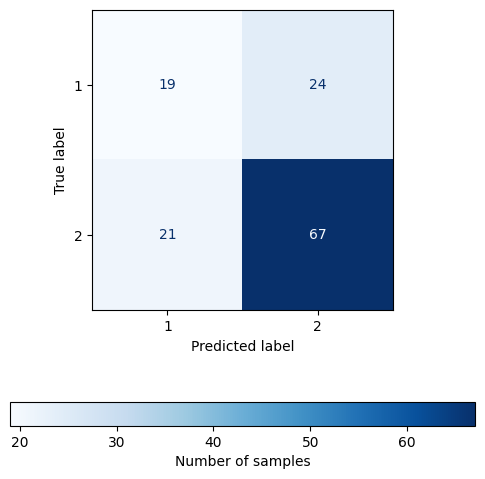

In [38]:
y_pred = model.predict(X_test_subset)
y_pred_label = [np.argmax(y) for y in y_pred]
evaluation(y_test_subset, y_pred_label)

## Long Short-Term Memory (LSTM) Network
Adapted from Natural Language Processing in Action book

In [39]:
from tensorflow.keras.layers import LSTM

model = Sequential()
model.add(Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32'))
model.add(embedding_layer)
model.add(Bidirectional(LSTM(
            100,
            return_sequences=False,
            input_shape=(MAX_SEQUENCE_LENGTH, EMBEDDING_DIM))))
model.add(Dropout(0.4))
model.add(Flatten())
model.add(Dense(2, activation='softmax'))

model.compile('rmsprop', 'sparse_categorical_crossentropy',  metrics=['accuracy'])

with tf.device('/gpu:0'):
    model.fit(X_train_subset,
              y_train_subset,
              epochs=20,
              batch_size=32,
              validation_split=0.1,
              class_weight=class_weights)

Epoch 1/20
14/14 [==============================] - 5s 90ms/step - loss: 0.6975 - accuracy: 0.5497 - val_loss: 0.7149 - val_accuracy: 0.4898
Epoch 2/20
14/14 [==============================] - 0s 19ms/step - loss: 0.6383 - accuracy: 0.6282 - val_loss: 0.6395 - val_accuracy: 0.6531
Epoch 3/20
14/14 [==============================] - 0s 16ms/step - loss: 0.5870 - accuracy: 0.7067 - val_loss: 0.6561 - val_accuracy: 0.6531
Epoch 4/20
14/14 [==============================] - 0s 16ms/step - loss: 0.5362 - accuracy: 0.7344 - val_loss: 0.6115 - val_accuracy: 0.6531
Epoch 5/20
14/14 [==============================] - 0s 16ms/step - loss: 0.5058 - accuracy: 0.7968 - val_loss: 0.6839 - val_accuracy: 0.5918
Epoch 6/20
14/14 [==============================] - 0s 16ms/step - loss: 0.4792 - accuracy: 0.7460 - val_loss: 0.5790 - val_accuracy: 0.7755
Epoch 7/20
14/14 [==============================] - 0s 15ms/step - loss: 0.4557 - accuracy: 0.7991 - val_loss: 0.5832 - val_accuracy: 0.7551
Epoch 8/20
14

5/5 [==============================] - 1s 9ms/step
accuracy: 0.7863


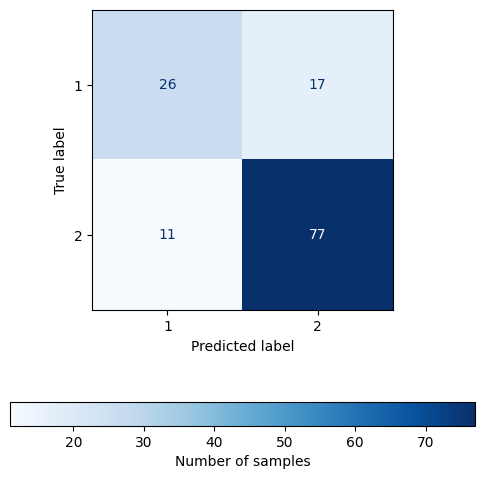

In [40]:
y_pred = model.predict(X_test_subset)
y_pred_label = [np.argmax(y) for y in y_pred]
evaluation(y_test_subset, y_pred_label)

In [41]:
# 1 through 5 star ratings
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)
x = Conv1D(128, 5, activation='relu')(embedded_sequences)
x = MaxPooling1D(3)(x)
x = Dropout(0.2)(x)
x = Conv1D(128, 5, activation='relu')(x)
x = MaxPooling1D(3)(x)
x = Dropout(0.2)(x)
x = Conv1D(64, 3, activation='relu')(x)
x = MaxPooling1D(3)(x)
x = Dropout(0.2)(x)
x = GlobalMaxPooling1D()(x)
x = Dropout(0.2)(x)
x = Flatten()(x)
x = Dense(64, activation='relu')(x)
preds = Dense(5, activation='softmax')(x)

model = Model(sequence_input, preds)
opt = tf.keras.optimizers.Adam(learning_rate=1e-3)
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

In [42]:
classes = [0, 1, 2, 3, 4]
class_weights = class_weight.compute_class_weight('balanced', classes=classes, y=y_train)
class_weights = dict(enumerate(class_weights))

In [43]:
model.fit(X_train,
          y_train,
          epochs=100,
          batch_size=64,
          validation_split=0.1,
          class_weight=class_weights)

y_pred = model.predict(X_test)
y_pred_label = [np.argmax(y) for y in y_pred]

Epoch 1/100
18/18 [==============================] - 4s 68ms/step - loss: 1.6594 - accuracy: 0.2301 - val_loss: 1.6096 - val_accuracy: 0.2016
Epoch 2/100
18/18 [==============================] - 0s 8ms/step - loss: 1.6124 - accuracy: 0.1787 - val_loss: 1.6052 - val_accuracy: 0.2097
Epoch 3/100
18/18 [==============================] - 0s 8ms/step - loss: 1.6028 - accuracy: 0.2139 - val_loss: 1.6118 - val_accuracy: 0.1371
Epoch 4/100
18/18 [==============================] - 0s 8ms/step - loss: 1.5970 - accuracy: 0.2220 - val_loss: 1.6119 - val_accuracy: 0.2177
Epoch 5/100
18/18 [==============================] - 0s 8ms/step - loss: 1.5795 - accuracy: 0.2653 - val_loss: 1.5955 - val_accuracy: 0.2581
Epoch 6/100
18/18 [==============================] - 0s 8ms/step - loss: 1.5514 - accuracy: 0.2681 - val_loss: 1.5778 - val_accuracy: 0.2903
Epoch 7/100
18/18 [==============================] - 0s 8ms/step - loss: 1.5263 - accuracy: 0.3032 - val_loss: 1.5603 - val_accuracy: 0.2823
Epoch 8/100


accuracy: 0.2792


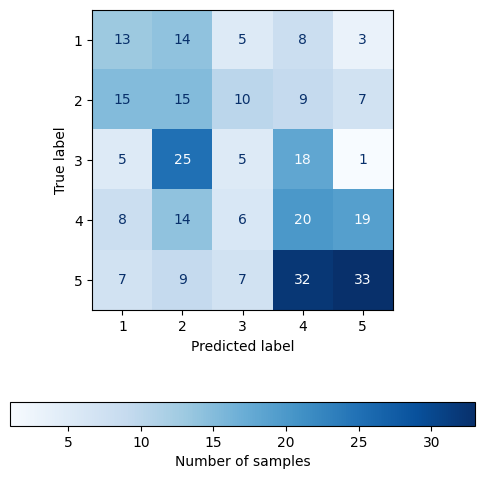

In [44]:
evaluation(y_test, y_pred_label)